<center><h1> Transfer Learning with Xception </h1></center>

---

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,Flatten,MaxPooling2D,Dropout
from keras.applications import Xception
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image

Using TensorFlow backend.


## Loading Images with Keras

This dataset comes from kaggle and is publicly available at:

https://www.kaggle.com/slothkong/10-monkey-species

Here we will see how easy Keras makes it to load in images and augment them for training using built in generator APIs. First we specify what kind of preprocessing and augmentation we would like to use with:

*keras.preprocessing.image.ImageDataGenerator()*

then we create our generator object which will be used to grab images from our specified directory with:

*ImageDataGenerator().flow_from_directory()*

In [10]:
height = 224
width = 224
channels = 3

# Get Images from Directories (Only Augment Training Images)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                 rotation_range = 30,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory('training/',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

valid_generator=valid_datagen.flow_from_directory('validation/',
                                                 target_size=(height,width),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Generators are generally the best way to load images into your model. Instead of loading all of the images into memory, you only load a single "batch" at a time making it much easier for your computer to deal with. 

Now that we have our generators set we can grab the next batch from the generator using *.next()*

## Class Visualizations

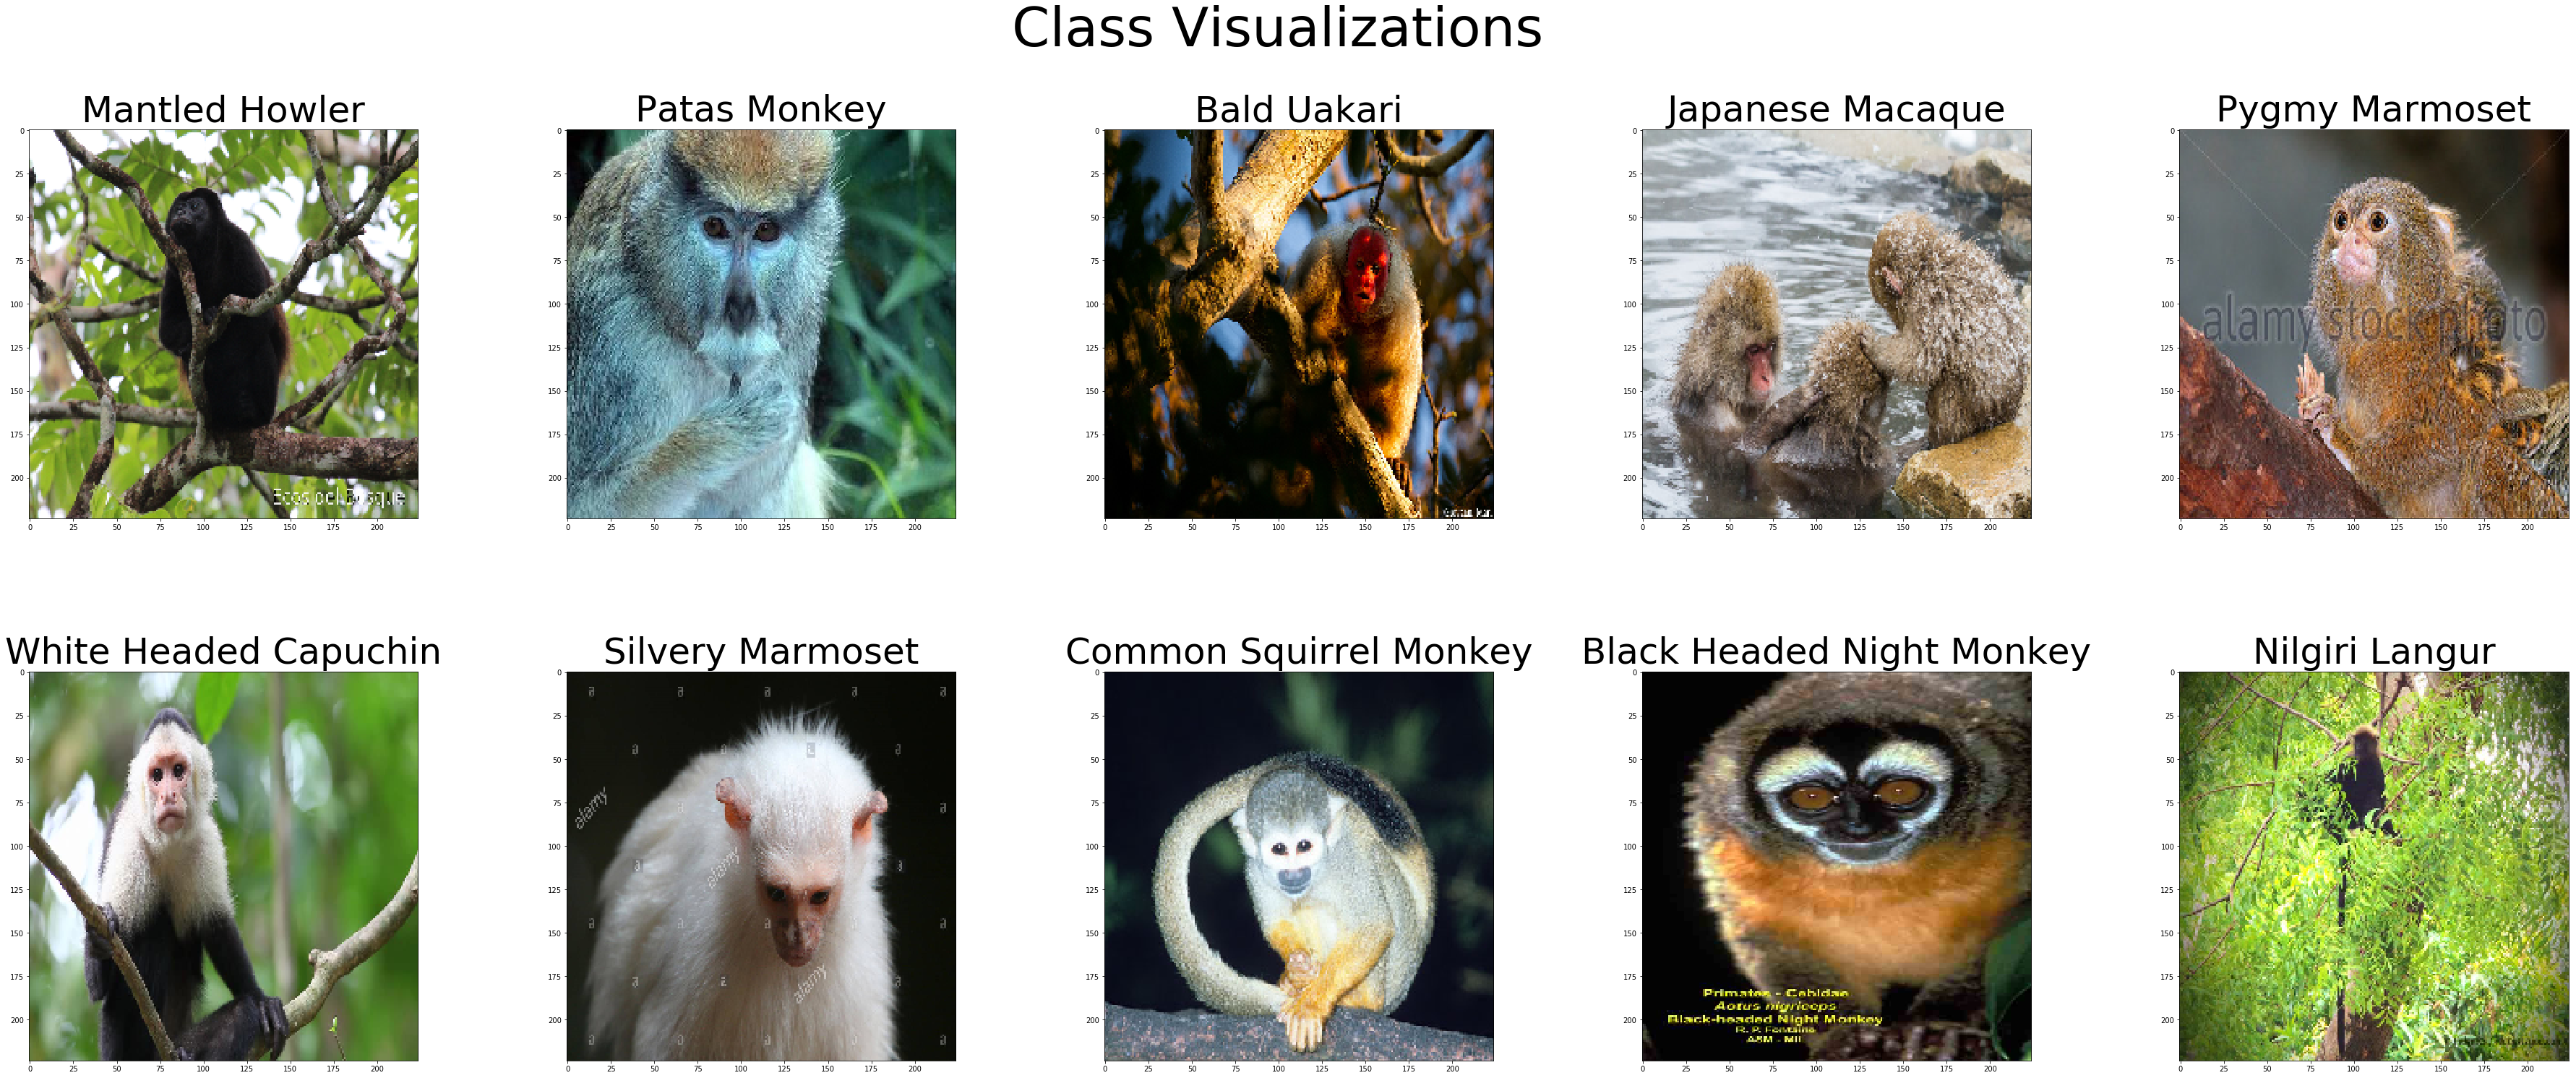

In [11]:
x,y = valid_generator.next()

labels = np.argmax(y,axis=1)

monkey_names = ['mantled_howler',
                'patas_monkey',
                'bald_uakari',
                'japanese_macaque',
                'pygmy_marmoset',
                'white_headed_capuchin',
                'silvery_marmoset',
                'common_squirrel_monkey',
                'black_headed_night_monkey',
                'nilgiri_langur',]

monkey_names = [i.title().replace('_',' ') for i in monkey_names]

f,axes = plt.subplots(2,5,figsize = (50,21))
axes = np.ravel(axes)

for i in range(10):
    index = np.argmax(labels==i)
    axes[i].imshow(x[index])
    axes[i].set_title(monkey_names[i],size = 50,y=1.01)
plt.suptitle('Class Visualizations',size = 75,y=1.03)
plt.tight_layout()

Above is a visualization of one image from each class. They are clearly quite diverse with some looking like they will be very difficult to classify. We only have a small number of images (~1000 Train and ~300 validation) so transfer learning is a good option. This lets us use pretrained weights from networks that have been trained on much larger sets of images and already have great ways of identifying features. Here we have selected Xception, a neural net created by google, that has been pretrained on imagenet. For more info on how some existing CNN models compare to each other check out the paper:

https://arxiv.org/abs/1810.00736

In [15]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(height,width,channels))

# Model Architecture
x=base_model.output
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)
preds=Dense(10,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

Here we can see that Xception is a fairly massive network, far more complicated than anything we've seen so far. But we are only going to worry about training the last few layers we added. We do this by freezing the weights (making them untrainable) of all but the last few layers we added.

Note: Right before our pooling layer we see that the output of Xception is (7,7,2048) we pooled this to reduce computational time. 

In [16]:
# Freeze Xception Base
for layer in model.layers[:-3]:
    layer.trainable=False
for layer in model.layers[-3:]:
    layer.trainable = True
    print(layer)

Now we are ready to compile our model. In order to use every image each epoch we will need to make the number of steps our generator takes equal to:

*total_number_of_images / batch_size*

this will be different for both the training and the validation sets

In [17]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size

#Assign Callback
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                    epochs=30,
                    validation_data = valid_generator,
                    validation_steps=step_size_valid,
                    callbacks=[early_stop])

Epoch 1/30
34/34 [==============================] - 40s 1s/step - loss: 2.5538 - acc: 0.5858 - val_loss: 0.6677 - val_acc: 0.8667
Epoch 2/30
34/34 [==============================] - 36s 1s/step - loss: 0.6694 - acc: 0.8161 - val_loss: 0.3813 - val_acc: 0.9292
Epoch 3/30
34/34 [==============================] - 37s 1s/step - loss: 0.4378 - acc: 0.8736 - val_loss: 0.7912 - val_acc: 0.8792
Epoch 4/30
34/34 [==============================] - 36s 1s/step - loss: 0.4297 - acc: 0.8662 - val_loss: 0.9660 - val_acc: 0.8555
Epoch 5/30
34/34 [==============================] - 36s 1s/step - loss: 0.4898 - acc: 0.8474 - val_loss: 0.5090 - val_acc: 0.8875
Epoch 6/30
34/34 [==============================] - 38s 1s/step - loss: 0.4467 - acc: 0.8694 - val_loss: 0.3357 - val_acc: 0.9375
Epoch 7/30
34/34 [==============================] - 37s 1s/step - loss: 0.4140 - acc: 0.8694 - val_loss: 0.2413 - val_acc: 0.9583
Epoch 8/30
34/34 [==============================] - 35s 1s/step - loss: 0.3586 - acc: 0.89

# Final Performance

Our transfer learning model does quite well at predicting each type of class, especially considering there are just over 1000 images to train on. A look into the confusion matrix for each image in the validation set will give us more insight into where our model is going wrong.

In [ ]:
final_generator=valid_datagen.flow_from_directory('validation/',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=272,
                                                  class_mode='categorical')

valid_images,valid_labels = final_generator.next()
valid_labels = np.argmax(valid_labels,axis=1)

In [24]:
predict_probas = model.predict(valid_images)
predictions = np.argmax(predict_probas,axis=1)

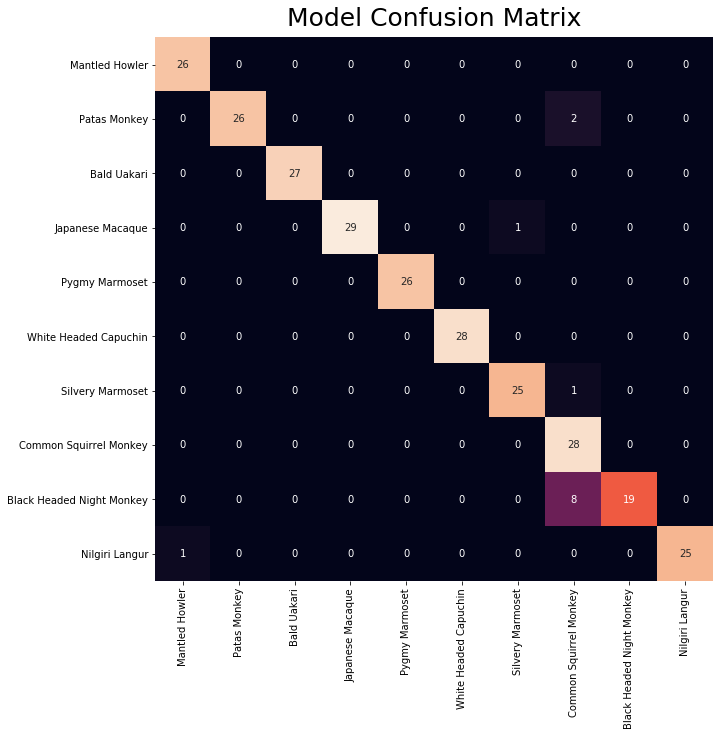

In [67]:
conf_mat = confusion_matrix(valid_labels,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            xticklabels=monkey_names,
            yticklabels=monkey_names,
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

 More than 50% of the mistakes in the model came from classifying Black Headed Night Monkeys as Common Squirel Monkeys. Lets take a look at these two classes to see why this might be the case.

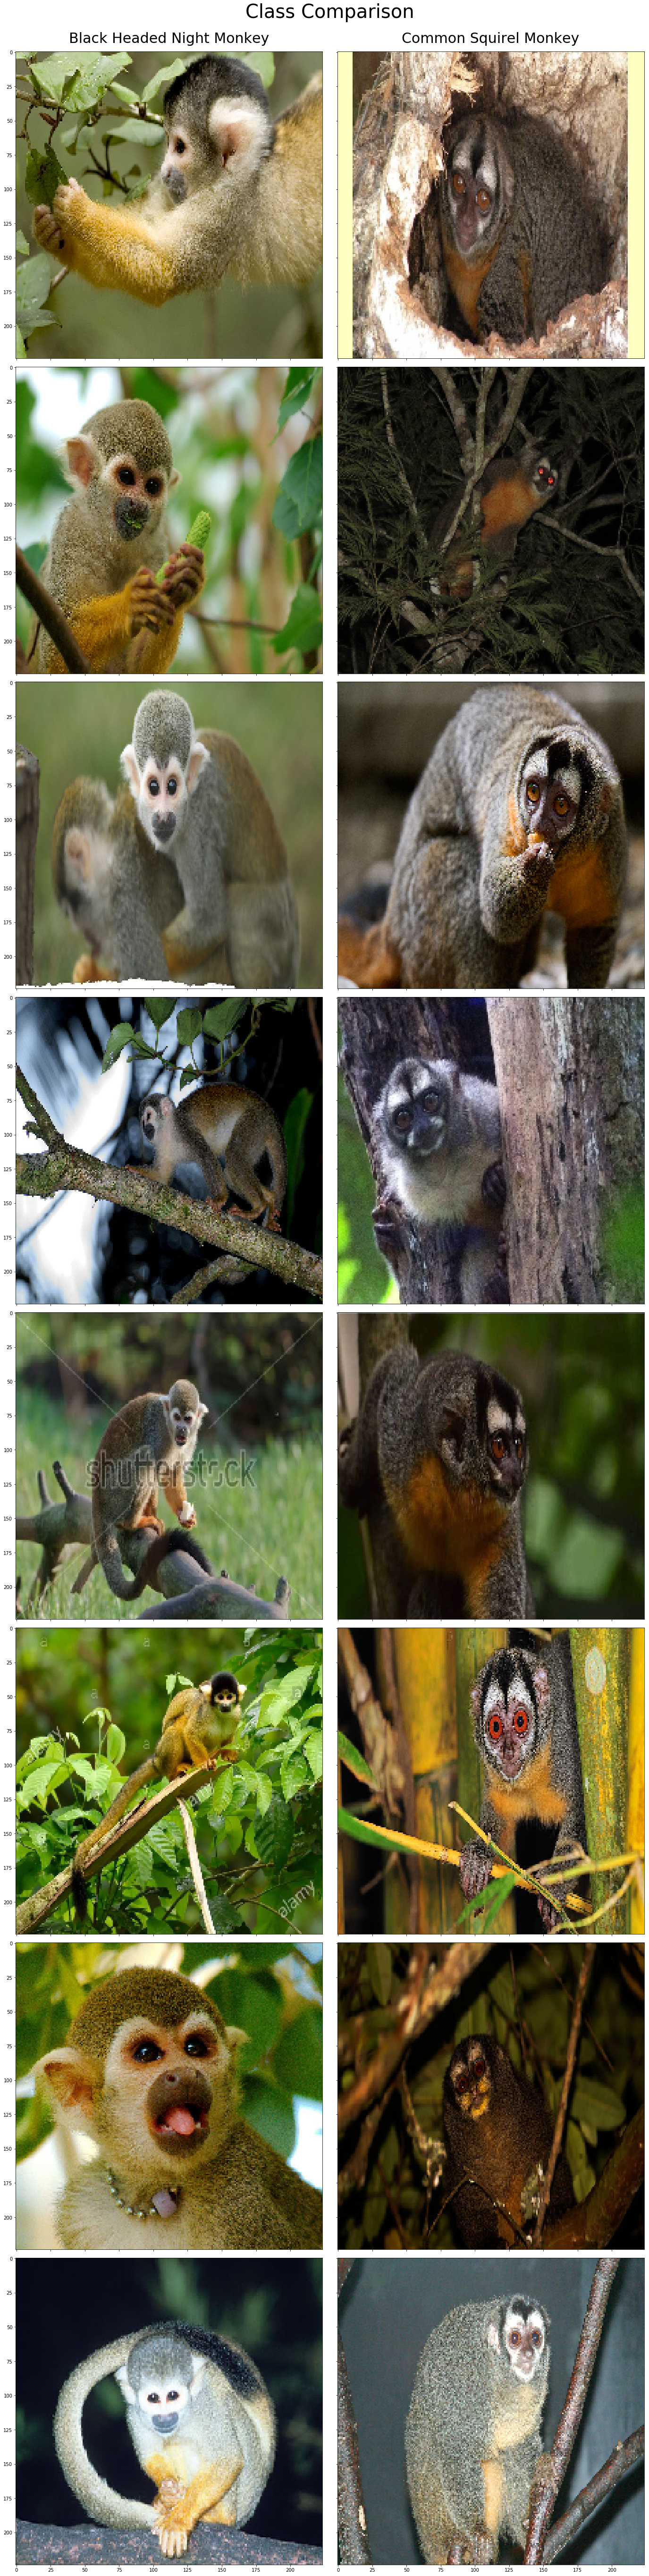

In [106]:
f,axes = plt.subplots(8,2,figsize = (20,75),sharex=True, sharey=True)
axes = np.ravel(axes)

for i,image in enumerate(valid_images[valid_labels==7][:8]):
    if not i:
        axes[i*2].set_title('Common Squirel Monkey',size = 30,y=1.02)
    axes[i*2].imshow(image)
    
for i,image in enumerate(valid_images[valid_labels==8][:8]):
    if not i:
        axes[i*2+1].set_title('Black Headed Night Monkey',size = 30,y=1.02)
    axes[i*2+1].imshow(image)

plt.suptitle('Class Comparison',size=40,y=1.01)
plt.tight_layout()
plt.show()

Some of the images do indeed look strikingly similar so it checks out that our model struggled with this class. Finally below is every image our model predicted wrongly.

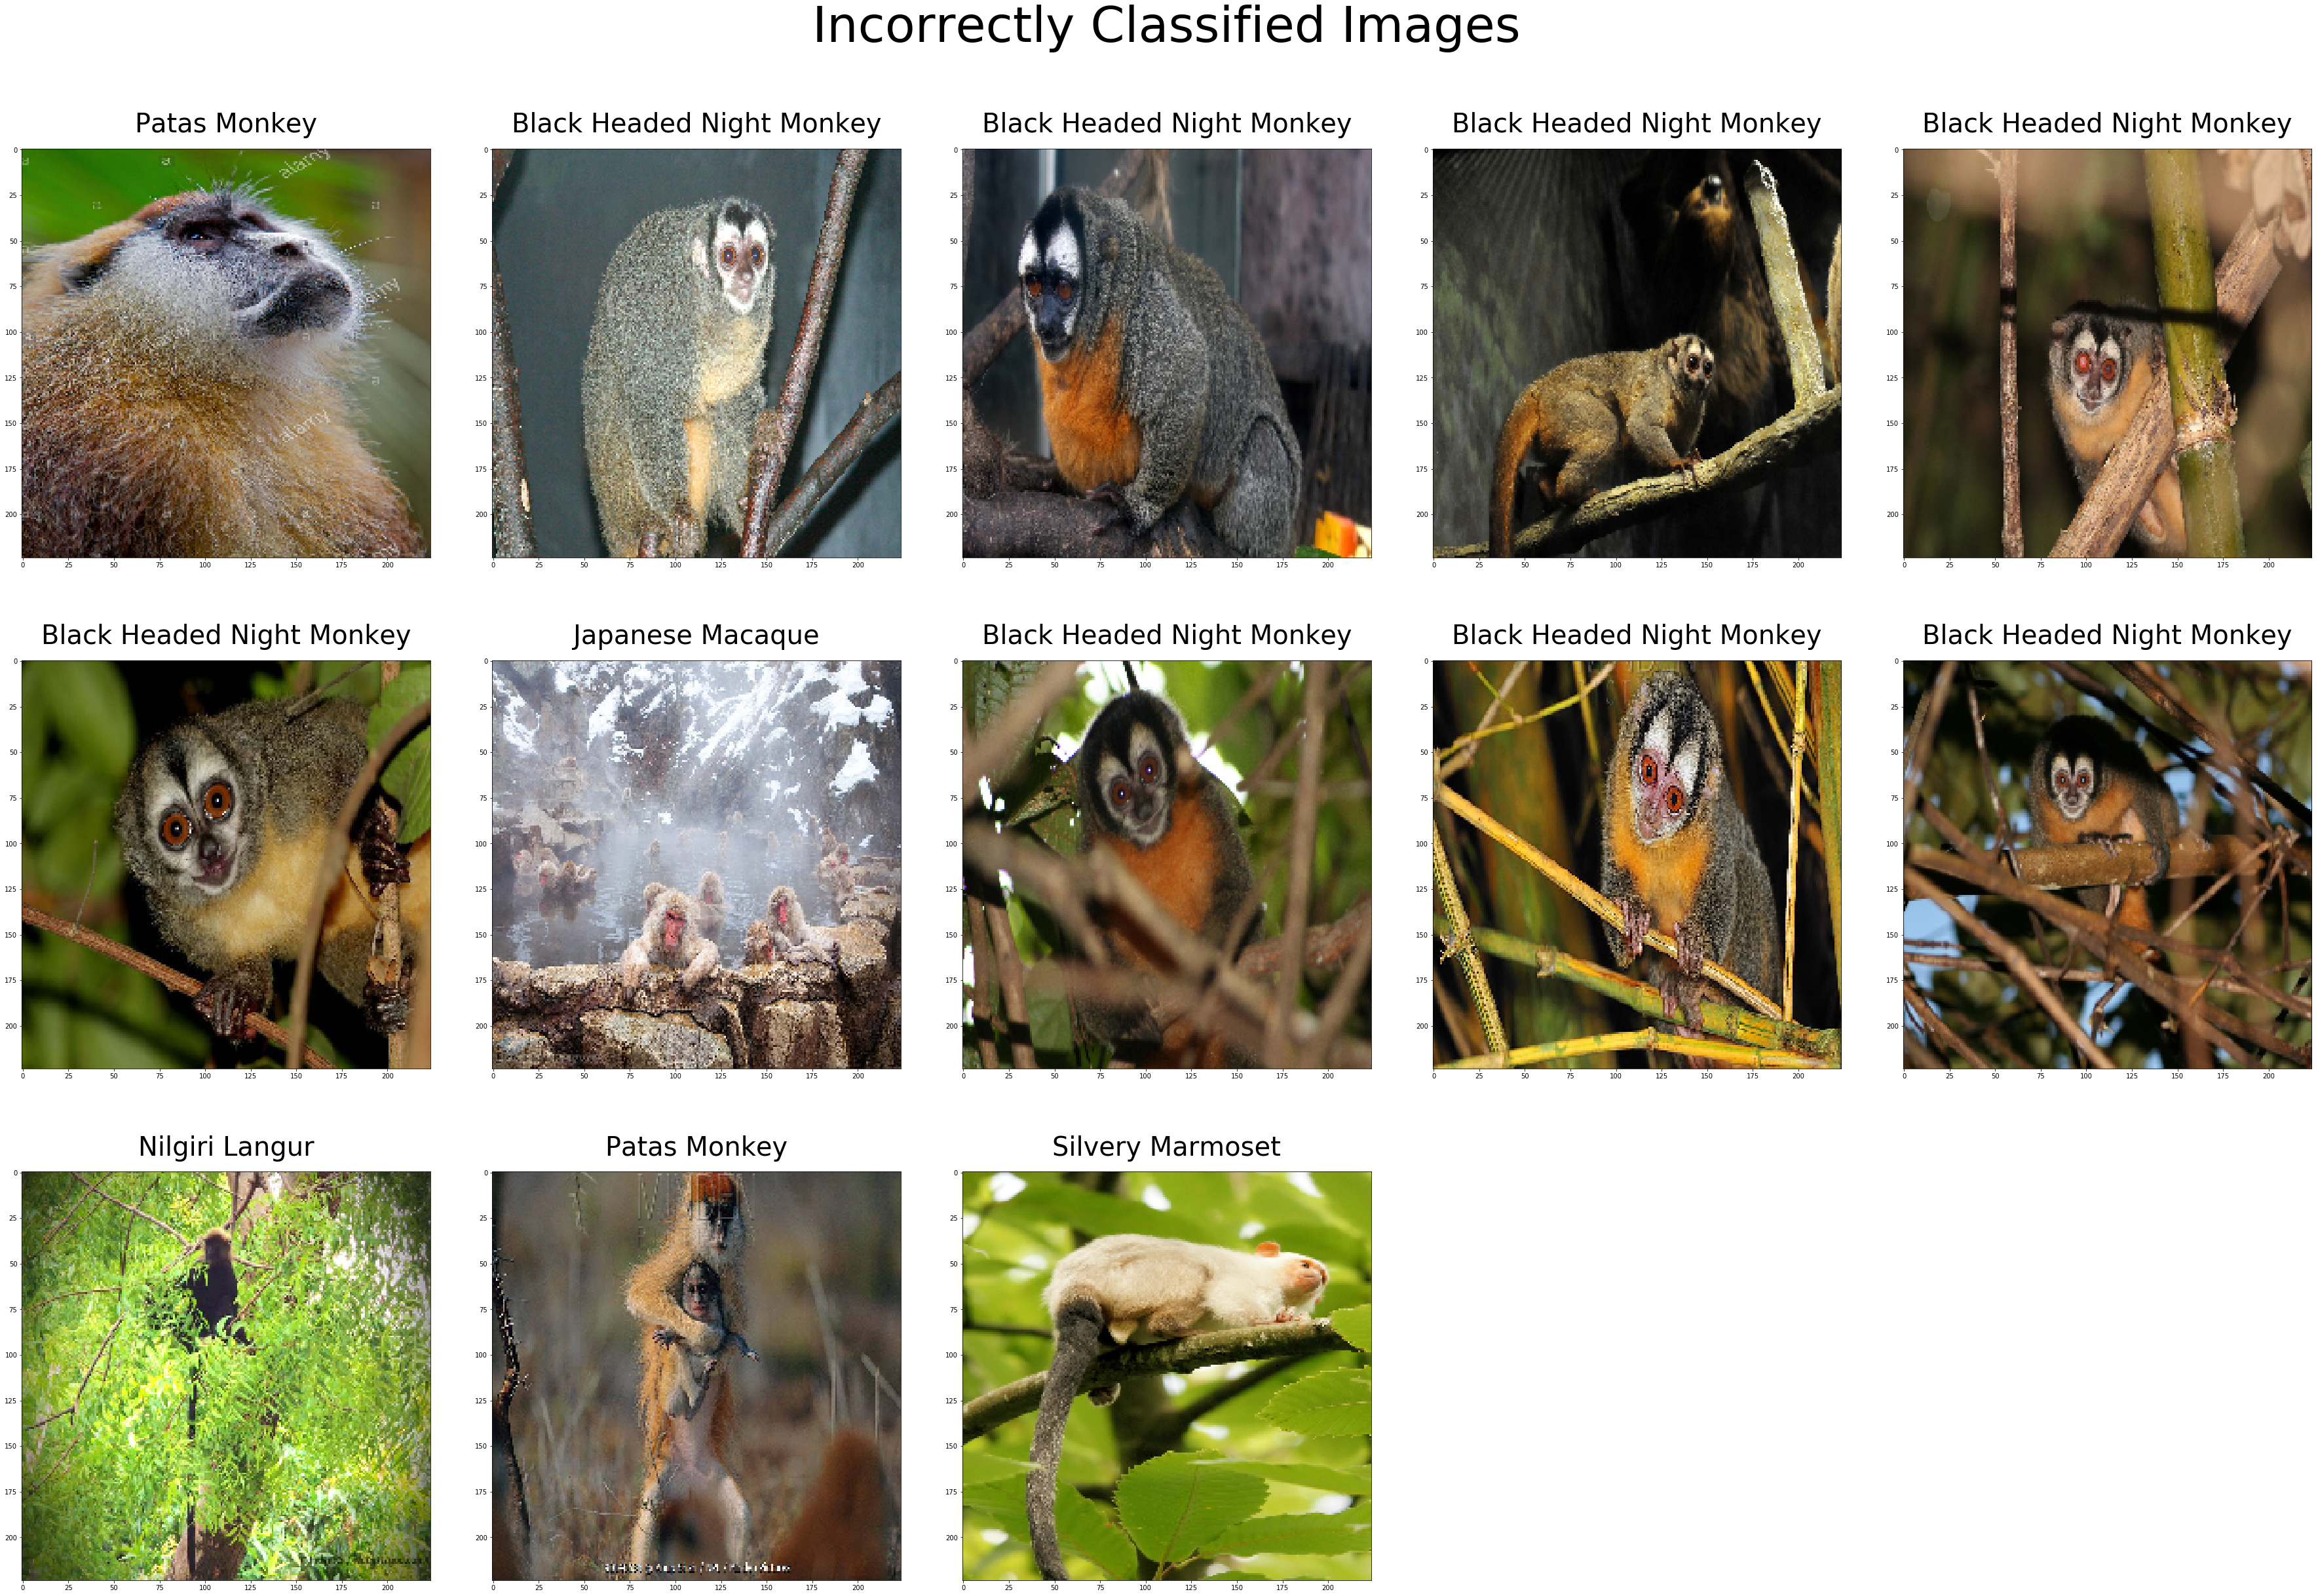

In [107]:
wrong_photos = valid_labels != predictions

f,axes = plt.subplots(3,5,figsize = (50,33),squeeze=False)
axes = np.ravel(axes)

for i,image in enumerate(valid_images[wrong_photos]):
    axes[i].imshow(image)
    axes[i].set_title(monkey_names[valid_labels[wrong_photos][i]],size = 40,y=1.03)

plt.suptitle('Incorrectly Classified Images',size=75,y=1.05)
plt.tight_layout()

f.delaxes(axes[-1])
f.delaxes(axes[-2])

plt.show()

Again misclassifications of the black headed monkey make up a huge portion of these but some of the others, such as the Nilgiri Langur photo appear to simply be difficult photos to predict because of the odd angles they were taken at.

---